# Development Notebook for the Advanced Fenestration Controller Wrapper

In [1]:
# !pip uninstall -y afc
# !pip install ..

### Imports for development only

In [2]:
# configure mpl
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72
%matplotlib inline

### ctrlWrapper.py

All Input variables: dict_keys(['paths', 'radiance', 'df_input', 'wf_all', 'facade_initial', 'temps_initial', 'parameter'])
Log-message:
 Duration [s]		0.22
Objective [$]		20.38			7.58 (Total Cost)
Cost [$]		13.31 (Energy)	6.98 (Demand)
CO2 Emissions [kg]		0.0

Duration:
 {'rad_duration': 6.4257283210754395, 'varts_duration': 0.14264965057373047, 'optall_duration': 0.3143491744995117, 'glare_duration': 65.06908798217773, 'opt_duration': 0.22385311126708984, 'outputs_duration': 0.006489753723144531, 'duration': 71.97169208526611}
Optimization:
 {'opt_objective': 20.38388962, 'opt_duration': 0.22385311126708984, 'opt_termination': 'optimal', 'duration': 71.97169208526611}


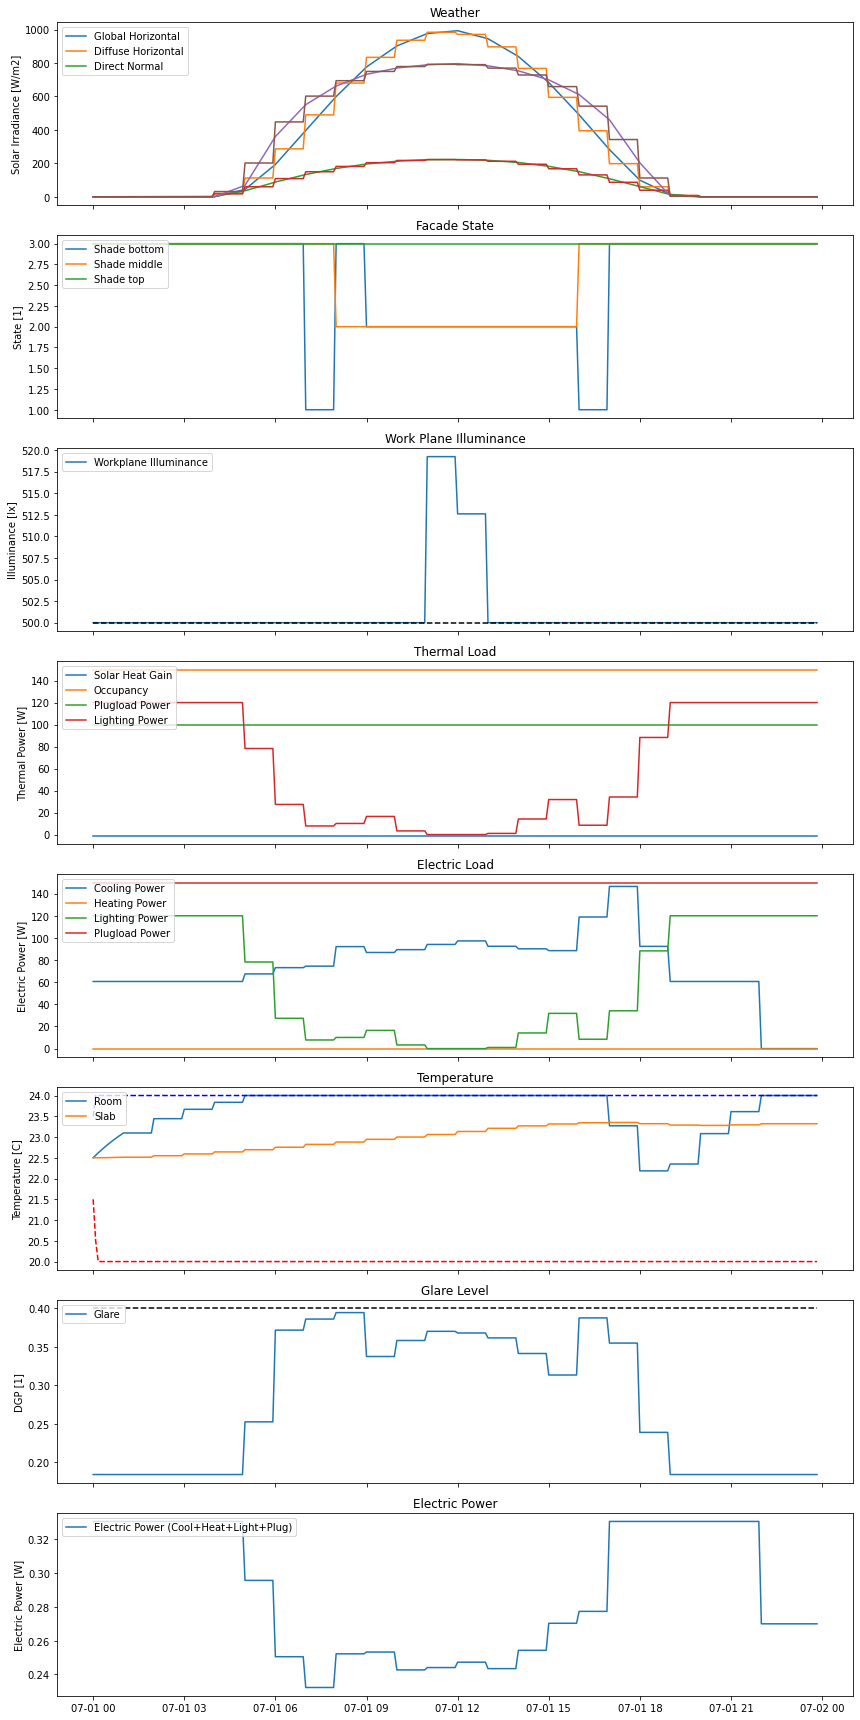

In [3]:
# Advanced Fenestration Controller (AFC) Copyright (c) 2023, The
# Regents of the University of California, through Lawrence Berkeley
# National Laboratory (subject to receipt of any required approvals
# from the U.S. Dept. of Energy). All rights reserved.

""""Advanced Fenestration Controller
Main controller wrapper module.
"""

# pylint: disable=invalid-name, bare-except, import-outside-toplevel
# pylint: disable=too-many-locals, redefined-outer-name, too-many-instance-attributes
# pylint: disable=too-many-branches, too-many-statements, broad-exception-caught
# pylint: disable=unused-variable

import os
import sys
import time
import json
import logging
import warnings
import traceback
import numpy as np
import pandas as pd

from fmlc.baseclasses import eFMU

try:
    root = os.path.dirname(os.path.abspath(__file__))
except:
    root = os.getcwd()

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

map_weather = {'dni':'weaHDirNor', 'dhi':'weaHDifHor'}

class Controller(eFMU):
    """Main controller wrapper class for the AFC."""

    def __init__(self):

        super().__init__()

        self.input = {
            'paths':None,
            'radiance':None,
            'df_input':None,
            'wf_all':None,
            'facade_initial':None,
            'temps_initial':None,
            'parameter':None}
        self.output = {
            'rad_duration':None,
            'varts_duration':None,
            'opt_objective':None,
            'glaremode':None,
            'opt_duration':None,
            'optall_duration':None,
            'opt_termination':None,
            'outputs_duration':None,
            'duration':None,
            'glare_duration':None,
            'uShade':None,
            'uTroom':None,
            'df_output':None}
        self.init = True
        self.root = root

        # Placeholder
        self.doper = None
        self.get_solver = None
        self.standard_report = None
        self.resample_variable_ts = None
        self.forecaster = None
        self.compute_periods = None
        self.get_tariff = None
        self.make_view_config = None
        self.view_config_from_rad = None
        self.glare_handler_class = None
        self.msg = None
        self.tariff = None
        self.controller = None
        self.glare_handler = None
        self.data = None
        self.res = None

    def init_functions(self):
        """Function to initialize controller."""

        rm_paths = [p for p in sys.path if 'Documents' in p]
        _ = [sys.path.remove(p) for p in rm_paths]

#         # Add to path
#         sys.path.append(self.root)
#         for path in self.input['paths'].values():
#             sys.path.append(path)

        # DOPER
        #sys.path.append(os.path.join(root, '..', '..', 'doper_private'))
        from doper import DOPER, get_solver, standard_report, resample_variable_ts, compute_periods
        from doper.data.tariff import get_tariff

        #from DOPER.wrapper import DOPER
        #from computetariff import compute_periods
        self.doper = DOPER
        self.get_solver = get_solver
        self.standard_report = standard_report
        self.resample_variable_ts = resample_variable_ts

        # Radiance modules
        from afc.radiance import forecast
        self.forecaster = forecast

        # Controller modules
        #from ComputeTariff import compute_periods
        self.compute_periods = compute_periods
        self.get_tariff = get_tariff

        # Glare logic
        #sys.path.append(os.path.join(self.input['paths']['emulator'], 'controller'))
        from afc.glare.view_angle import make_view_config, view_config_from_rad
        from afc.glare.sage3zone import Sage3zone
        self.make_view_config = make_view_config
        self.view_config_from_rad = view_config_from_rad
        self.glare_handler_class = Sage3zone

    def log_results(self):
        """Function to log results."""

        log_dir = self.input['parameter']['wrapper']['log_dir']
        if not os.path.exists(log_dir):
            os.mkdir(log_dir)
        log_dir = os.path.join(log_dir, str(self.input['parameter']['wrapper']['instance_id']))
        if not os.path.exists(log_dir):
            os.mkdir(log_dir)
        fname = str(self.data.index[0]).replace(' ','').replace(':','')
        with open(os.path.join(log_dir, fname+'.txt'), 'w', encoding='utf8') as f:
            json.dump(self.controller.parameter, f)
        self.data.to_csv(os.path.join(log_dir, fname+'.csv'))

    def compute(self):
        """Main compute function."""

        try:
            st = time.time()
            self.msg = ''

            # Parse input dataframe
            inputs = pd.DataFrame().from_dict(self.input['df_input'])
            inputs.index = pd.to_datetime(inputs.index)#, unit='ms')

            # Setup controller
            if self.init:
                self.init_functions()
                from afc.optModel import control_model#, pyomo_to_pandas
                if self.input['parameter']['wrapper']['solver_dir']:
                    solver_path = \
                        self.get_solver(self.input['parameter']['wrapper']['solver_name'],
                                        solver_dir=self.input['parameter']['wrapper']['solver_dir'])
                else:
                    solver_path = self.get_solver(self.input['parameter']['wrapper']['solver_name'])
                pyomo_logger = \
                    logging.WARNING if self.input['parameter']['wrapper']['printing'] else \
                        logging.ERROR
                self.tariff = self.get_tariff(self.input['parameter']['wrapper']['tariff_name'])
                output_list = self.input['parameter']['wrapper']['output_list']
                self.controller = self.doper(model=control_model,
                                             parameter=self.input['parameter'],
                                             solver_path=solver_path,
                                             pyomo_logger=pyomo_logger,
                                             output_list=output_list)
                filestruct = {}
                filestruct['resources'] = self.input['paths']['rad_bsdf']
                filestruct['matrices'] = self.input['paths']['rad_mtx']
                self.forecaster = \
                    self.forecaster.Forecast(self.input['paths']['rad_config'],
                                             regenerate=self.input['radiance']['regenerate'],
                                             location=self.input['radiance']['location'],
                                             facade_type=self.input['parameter']['facade']['type'],
                                             wpi_loc=self.input['radiance']['wpi_loc'],
                                             filestruct=filestruct,
                                             dimensions=self.input['radiance']['dimensions'])
                if self.input['parameter']['wrapper']['precompute_radiance']:
                    wf_all = pd.DataFrame().from_dict(self.input['wf_all'])
                    wf_all.index = pd.to_datetime(wf_all.index, unit='ms')
                    temp = pd.DataFrame()
                    for d in sorted(np.unique(wf_all.index.date)):
                        if temp.empty:
                            tt = wf_all[['dni','dhi']][wf_all.index.date == d]
                            temp = self.forecaster.compute2(tt)
                        else:
                            temp = pd.concat([temp, self.forecaster.compute2( \
                                wf_all[['dni','dhi']][wf_all.index.date == d])])
                    self.forecaster = temp

                # Glare handler
                view_config = self.view_config_from_rad(self.input['paths']['rad_config'],
                                                        start_lx=20e3, end_lx=12.5e3)
                self.glare_handler = \
                    self.glare_handler_class(config=self.input['radiance']['location'],
                                             view_config=view_config)
                if self.input['parameter']['wrapper']['precompute_radiance']:
                    wf = wf_all[['dni','dhi']].copy(deep=True).rename(columns=map_weather)
                    for ix in wf.index:
                        wf.loc[ix, ['alt', 'azi_shift', 'inci', 'azi']] = \
                            self.glare_handler.get_solar(ix, wf.loc[ix:ix])
                        gmodes = self.glare_handler.glare_mode_many( \
                            *wf.loc[ix, ['alt', 'azi_shift', 'inci']].values)
                        for i, g in enumerate(gmodes):
                            wf.loc[ix, f'zone{i}_gmode'] = int(g)
                    self.glare_handler = wf

            # Compute radiance
            st1 = time.time()

            if self.input['parameter']['wrapper']['precompute_radiance']:
                data = self.forecaster.loc[inputs.index]
            else:
                data = self.forecaster.compute2(inputs[['dni','dhi']])
            # cutoff
            rad_cutoff = self.input['parameter']['facade']['rad_cutoff']
            for k in rad_cutoff.keys():
                for c in data.columns:
                    if k in c:
                        data.loc[:,c] = data[c].mask(data[c] < rad_cutoff[k][0], 0)
                        data.loc[:,c] = data[c].mask(data[c] > rad_cutoff[k][1], rad_cutoff[k][1])
            self.output['rad_duration'] = time.time() - st1

            # Glare handler
            st1 = time.time()
            if self.input['parameter']['wrapper']['precompute_radiance']:
                wf = self.glare_handler.loc[inputs.index]
            else:
                wf = inputs[['dni','dhi']].copy(deep=True).rename(columns=map_weather)
                for ix in wf.index:
                    wf.loc[ix, ['alt', 'azi_shift', 'inci', 'azi']] = \
                        self.glare_handler.get_solar(ix, wf.loc[ix:ix])
                    gmodes = self.glare_handler.glare_mode_many( \
                        *wf.loc[ix, ['alt', 'azi_shift', 'inci']].values)
                    for i, g in enumerate(gmodes):
                        wf.loc[ix, f'zone{i}_gmode'] = int(g)

            zones = self.input['parameter']['facade']['windows']
            states = self.input['parameter']['facade']['states']
            flip_z = 'shade' in self.input['parameter']['facade']['type']
            if self.input['parameter']['facade']['type'] == 'blinds':
                darkstates = [s for s in states if s not in [0, 9, 10, 11]] # Specific for blinds
            else:
                darkstates = states[1:]
            gmodes = []
            for nz, z in enumerate(zones):
                for t in darkstates:
                    wf_key = f'zone{t if flip_z else nz}_gmode'
                    if not wf_key in wf.columns:
                        wf_key = f'zone{t-1 if flip_z else nz-1}_gmode'
                    gmodes.append(wf.loc[wf.index[0], wf_key])
                    data[f'ev_{nz}_{t}'] =  data[f'ev_{nz}_{t}'].mask( \
                        (wf[wf_key] > 0) & (data[f'wpi_{nz}_{t}']>0), 2e4)
            self.output['glare_duration'] = time.time() - st1

            # Compute other inputs
            data = pd.concat([data, inputs], axis=1)
            data['oat'] = inputs['temp_air']
            data['wind_speed'] = inputs['wind_speed']
            data['battery_0_avail'] = 0
            data['battery_0_demand'] = 0
            data['battery_reg'] = 0

            # Update SOC
            self.input['parameter']['zone']['temps_initial'] = self.input['temps_initial']
            self.input['parameter']['zone']['fstate_initial'] = self.input['facade_initial']

            # Variable timestep
            st1 = time.time()
            if self.input['parameter']['wrapper']['resample_variable_ts']:

                # check columns
                cols = self.input['parameter']['wrapper']['cols_fill']
                if not 'temp_room_max' in cols[0].lower():
                    print('ERROR: "temp_room_max" is not in first column of "cols_fill".')

                # ensure ramp when occupancy starts
                for ix in data.index[data[cols[0]].diff()<0]:
                    ix_st = max(data.index[0]+pd.DateOffset(minutes=5),
                                ix-pd.DateOffset(minutes=55))
                    data.loc[ix_st:ix-pd.DateOffset(minutes=5), cols] = np.nan
                data = \
                    data.resample(f'{(data.index[1]-data.index[0]).total_seconds()}S').interpolate()

                # ensure resampling when occupancy ends
                for ix in data.index[data[cols[0]].diff()>0]:
                    data.loc[ix, cols] = \
                        data.loc[data.index[max(0, data.index.get_loc(ix)-1)], cols].values

                # limit starting ramp
                t_init = self.input['temps_initial'][0]
                data[cols[0]] = \
                    np.min([[t_init+(i+1)*self.input['parameter']['wrapper']['limit_slope'] \
                             for i in range(len(data))], data[cols[0]]], axis=0)
                data[cols[1]] = \
                    np.max([[t_init-(i+1)*self.input['parameter']['wrapper']['limit_slope'] \
                             for i in range(len(data))], data[cols[1]]], axis=0)

                # resample
                data = self.resample_variable_ts(data, \
                    reduced_start=int(self.input['parameter']['wrapper']['reduced_start']),
                    reduced_ts=int(self.input['parameter']['wrapper']['reduced_ts']),
                    cols_fill=self.input['parameter']['wrapper']['cols_fill'])
            self.output['varts_duration'] = time.time() - st1

            # Compute and update tariff
            data, _ = self.compute_periods(data, self.tariff, self.input['parameter'])

            # Check for nan
            if pd.isnull(data).any().any():
                print(data)
                data.to_csv('error_controller_inputs.csv')
                raise ValueError('NAN values in MPC input. Index:',
                                 data.index[pd.isnull(data).any().to_numpy().nonzero()[0]])

            # Run optimization
            st1 = time.time()
            self.data = data.round(self.input['parameter']['wrapper']['inputs_cutoff'])

            # Store for debug
            # data.to_csv('inputs_{}.csv'.format(data.index[0]))
            # cfg = {}
            # cfg['parameter'] = self.input['parameter']
            # cfg['options'] = self.input['parameter']['options']
            # with open('cfg_{}.json'.format(data.index[0]), 'w') as f:
            #     f.write(json.dumps(cfg))

            print_error = self.input['parameter']['wrapper']['printing']
            self.res = \
                self.controller.do_optimization(self.data, parameter=self.input['parameter'],
                                                options=self.input['parameter']['solver_options'],
                                                tee=self.input['parameter']['wrapper']['printing'],
                                                print_error=print_error)
            duration, objective, df, model, result, termination, parameter = self.res
            self.output['optall_duration'] = time.time() - st1

            # Write outputs
            st1 = time.time()
            self.output['opt_duration'] = float(duration)
            self.output['opt_termination'] = str(termination)
            self.output['opt_objective'] = float(objective) if objective else np.nan
            self.output['glaremode'] = list(gmodes)
            if objective:
                uShade = df[[f'Facade State {z}' for \
                    z in self.input['parameter']['facade']['windows']]].iloc[0].values
                #uShade = df[['Tint Bottom [-]', 'Tint Middle [-]', 'Tint Top [-]']].iloc[0].values
                self.output['uShade'] = [round(float(u),1) for u in uShade]
                self.output['uTroom'] = float(df['Temperature 0 [C]'].values[1])
            df = pd.concat([df, data], axis=1)
            df.index = (df.index.astype(np.int64) / 10 ** 6).astype(str)
            df = df.fillna(-1)
            self.output['df_output'] = df.to_dict()
            self.output['duration'] = time.time() - st
            self.output['outputs_duration'] = time.time() - st1

            # Store if long optimization
            if self.output['duration'] > self.input['parameter']['wrapper']['log_overtime']:
                self.log_results()

            self.init = False
            self.msg += self.standard_report(self.res)

        except Exception as e:
            self.msg += f'\nERROR: {e}\n\n{traceback.format_exc()}'
        return self.msg

def make_inputs(parameter, df):
    """Utility function to make inputs."""

    df = df.copy(deep=True)

    # Internal demand
    df.loc[:, 'plug_load'] = parameter['occupant']['plug_load'] # W
    df.loc[:, 'occupant_load'] = parameter['occupant']['occupant_load'] # W
    df.loc[:, 'equipment'] = parameter['occupant']['equipment'] # W
    df.loc[:, 'occupancy_light'] = parameter['occupant']['occupancy_light'] # 0-unocc, 1-occ

    # Occupant constraints
    df.loc[:, 'wpi_min'] = parameter['occupant']['wpi_min']
    df.loc[:, 'glare_max'] = parameter['occupant']['glare_max']
    df.loc[:, 'temp_room_max'] = parameter['occupant']['temp_room_max']
    df.loc[:, 'temp_room_min'] = parameter['occupant']['temp_room_min']

    # Time-variable schedule
    if parameter['occupant']['schedule']:
        print('ERROR: Not implemented!')
        raise NotImplementedError

    # Default inputs
    df.loc[:, 'generation_pv'] = 0
    df.loc[:, 'load_demand'] = 0
    df.loc[:, 'temp_slab_max'] = 1e3
    df.loc[:, 'temp_slab_min'] = 0
    df.loc[:, 'temp_wall_max'] = 1e3
    df.loc[:, 'temp_wall_min'] = 0

    # Map parameter and make Inputs object
    inputs = {}
    inputs['radiance'] = parameter['radiance']
    inputs['df_input'] = df.to_dict()
    inputs['wf_all'] = None
    inputs['facade_initial'] = parameter['facade']['fstate_initial']
    inputs['temps_initial'] = parameter['zone']['temps_initial']
    inputs['parameter'] = parameter
    inputs['paths'] = parameter['radiance']['paths']

    return inputs

if __name__ == '__main__':
    import datetime as dtm

    root = os.getcwd()

    from afc.utility.weather import read_tmy3
    # from afc.radiance.configs import get_config
    from afc.defaultConfig import default_parameter
    from afc.utility.plotting import plot_standard1

    # read weather (forecast) data
    weather_path = os.path.join(os.path.dirname(root), 'dev', 'resources', 'weather',
        'USA_CA_San.Francisco.Intl.AP.724940_TMY3.csv')
    weather, info = read_tmy3(weather_path, coerce_year=2023)
    weather = weather.resample('5T').interpolate()
    st = dtm.datetime(2023, 7, 1)
    wf = weather.loc[st:st+pd.DateOffset(hours=24),]
    wf = wf[['temp_air','dni','dhi','wind_speed']+['ghi']].copy()
    wf = wf[wf.index.date == wf.index[0].date()]

    # Initialize controller
    ctrl = Controller()

    # Get all variables
    print('All Input variables:', ctrl.get_model_variables())

    parameter = default_parameter(precompute_radiance=False)
    inputs = make_inputs(parameter, wf)

    # Query controller
    ctrl.do_step(inputs=inputs) # Initialize
    print('Log-message:\n', ctrl.do_step(inputs=inputs))
    print('Duration:\n', ctrl.get_output(keys=['rad_duration', 'varts_duration',
                                               'optall_duration', 'glare_duration',
                                               'opt_duration', 'outputs_duration', 'duration']))
    print('Optimization:\n', ctrl.get_output(keys=['opt_objective', 'opt_duration',
                                                   'opt_termination', 'duration']))
    df = pd.DataFrame(ctrl.get_output(keys=['df_output'])['df_output'])
    df.index = pd.to_datetime(pd.to_numeric(df.index), unit='ms')

    try:
        # Remove slab constraints for plotting
        df['Temperature 1 Min [C]'] = None
        df['Temperature 1 Max [C]'] = None
        plot_standard1(pd.concat([wf, df], axis=1).ffill().iloc[:-1])
    except:
        pass
